In [9]:
%matplotlib inline
import random
random.seed(0)
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

import timeit
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict
from sklearn.metrics import  confusion_matrix,adjusted_rand_score
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn import metrics
from sklearn.decomposition import PCA,FastICA
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import optimizers

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

skips = 2
X_train=np.delete(X_train, list(range(0, X_train.shape[1], skips)), axis=1)
X_train=np.delete(X_train, list(range(0, X_train.shape[2], skips)), axis=2)
X_train = X_train.reshape(X_train.shape[0],-1)

X_test = np.delete(X_test, list(range(0, X_test.shape[1], skips)), axis=1)
X_test = np.delete(X_test, list(range(0, X_test.shape[2], skips)), axis=2)
X_test = X_test.reshape(X_test.shape[0],-1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

idx_train = np.random.choice(60000, size = 10000, replace = False)
idx_test = np.random.choice(10000, size = 1000, replace = False)
X_train, y_train = X_train[idx_train], y_train[idx_train]
X_test, y_test = X_test[idx_test], y_test[idx_test]

## MLP with PCA 

In [3]:
dims = [i for i in range(36,197,40)]
nn_arch=[(100),(100,100),(100,100,100), (100,100,100,100),(100,100,100,100,100)]

grid ={'ica__n_components':dims,'NN__hidden_layer_sizes':nn_arch}
ica = FastICA(random_state=5)
mlp = MLPClassifier(max_iter=5000,early_stopping=True,random_state=5, learning_rate='adaptive')
pipe = Pipeline([('ica',ica),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5, n_jobs=-1)

gs.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 23.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ica', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=5, tol=0.0001, w_init=None,
    whiten=True)), ('NN', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, e...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ica__n_components': [36, 76, 116, 156, 196], 'NN__hidden_layer_sizes': [100, (100, 100), (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [4]:
tmp = pd.DataFrame(gs.cv_results_)
tmp.to_csv('mnist_ica_nn.csv')

In [5]:
best_params = gs.best_params_
print("Best parameters set for Neural network:")
print(best_params)
pred_best = gs.predict(X_test)
best_accuracy = accuracy_score(y_test, pred_best)
print('Accuracy of Neural network: is %.2f%%' % (best_accuracy * 100))

Best parameters set for Neural network:
{'NN__hidden_layer_sizes': (100, 100, 100), 'ica__n_components': 116}
Accuracy of Neural network: is 92.10%


In [6]:
print(classification_report(y_test, gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       100
           1       0.99      0.99      0.99       127
           2       0.92      0.90      0.91       102
           3       0.89      0.92      0.91       120
           4       0.89      0.95      0.92       102
           5       0.93      0.85      0.89        87
           6       0.92      0.96      0.94        93
           7       0.87      0.89      0.88        82
           8       0.93      0.87      0.90        93
           9       0.93      0.87      0.90        94

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [10]:
# https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(15,15)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

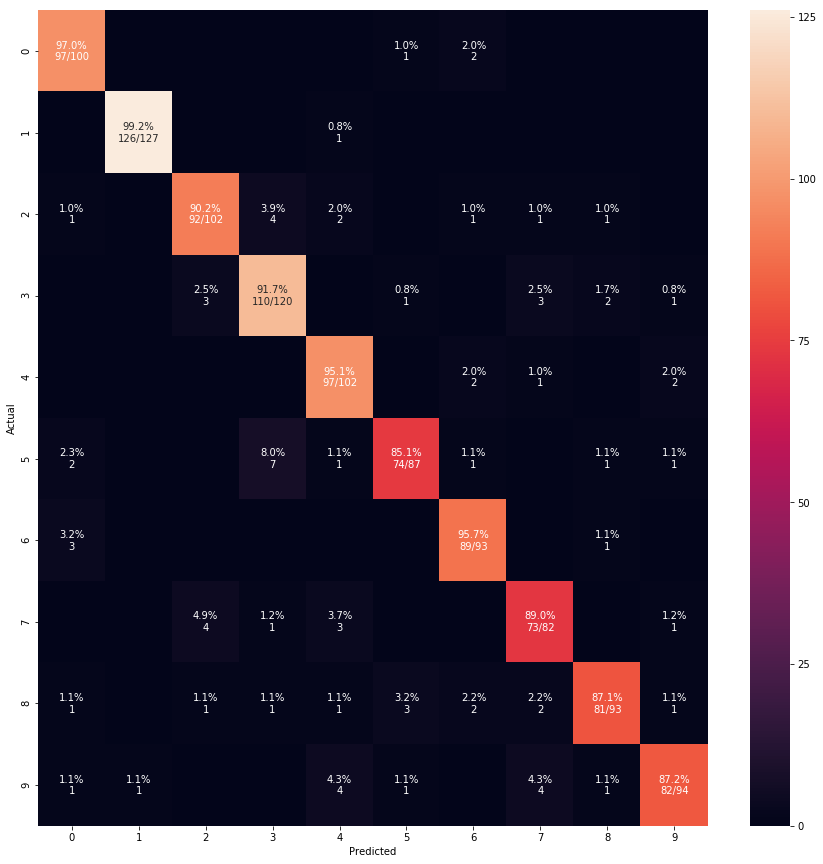

In [11]:
cm_analysis(y_test, gs.predict(X_test), range(10))